In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcol
import cartopy.crs as ccrs
import cmocean
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.optimize as scopt
from functools import partial
import viz
import mplRC
import extremespaper as ex
import os
mplRC.paperRC2();

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy39dc/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
exdir=ex.exdirs
varlist=['tos','omega_arag_0','hplusos','spco2',]
freq='daily'
scenList=['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1'] #'ESM4_ssp245_D1','ESM4_ssp534-over_D1',

stats=ex.load_stats(scenList,varlist,freq=freq)

ffi=stats['ESM4_historical_D1']['omega_arag_0']
wgt=xr.DataArray(data=viz.areacello1x1,
            coords={'lat': ffi.lat,'lon': ffi.lon}, 
            dims=["lat", "lon"])#.stack(xy=['lat','lon'])

In [3]:
stats['ESM4_historical_D1']['hplusos']

<xarray.Dataset> Size: 12GB
Dimensions:      (time: 1, lat: 180, lon: 360, quantile: 13, b: 2, YD: 365,
                  YD5: 73)
Coordinates:
  * lat          (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon          (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time         (time) object 8B 1995-01-01 00:00:00
  * YD           (YD) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * quantile     (quantile) float64 104B 0.0 0.02 0.05 0.07 ... 0.95 0.98 1.0
  * b            (b) int64 16B 0 1
  * YD5          (YD5) int64 584B 1 6 11 16 21 26 31 ... 336 341 346 351 356 361
Data variables: (12/22)
    mean         (time, lat, lon) float32 259kB ...
    var          (time, lat, lon) float32 259kB ...
    qt           (quantile, lat, lon) float64 7MB ...
    linfitcoef   (b, lat, lon) float64 1MB ...
    binseas      (YD, lat, lon) float64 189MB ...
    seas         (YD, lat, lon) float64 189MB ...
    ...           ...
    ydqt_ds2     (YD5, quantile, lat, lon) float64 492MB ...
    ydqt_dtds2   (YD5, quantile, lat, lon) float64 492MB ...
    ydqt2S       (YD, quantile, lat, lon) float64 2GB ...
    ydqt_dt2S    (YD, quantile, lat, lon) float64 2GB ...
    ydqt_ds2S    (YD, quantile, lat, lon) float64 2GB ...
    ydqt_dtds2S  (YD, quantile, lat, lon) float64 2GB ...
Attributes:
    long_name:                   Hydrogen Ion Concentration
    units:                       micromol/l
    varname:                     hplusos
    year-day quantile Descript:  full series fits are applied to dt and ds va...
    ydqt halfwindow:             2

In [4]:
devs=dict()
scen='ESM4_historical_D1'
qqh=.95
qql=.05
for ivar in varlist:
    A=1e6/101325 if ivar=='spco2' else 1
    qq=qqh if exdir[ivar]>0 else qql
    with xr.open_dataset(ex.fNameAnnualExtremes(scen,ex.dictScenDates[scen],freq,ivar)) as ff:
        devs[(scen,ivar)]=ff['an_qt_dt'].sel(quantile=qq).std(dim='year').load()*A

In [5]:
def _repl(fig,ax): # replace axes projection axes with normal axes
    pos=ax.get_position()
    ax.remove()
    ax=fig.add_axes(pos.bounds,projection=None)#[0],0.1,.01,0.8
    return ax

In [6]:
cm1=cmocean.cm.haline
cm1.set_bad('k',alpha=0)
cmb=cmocean.cm.balance
cmb.set_bad('tan',alpha=0)
lons=viz.lonvec1x1
lats=viz.latvec1x1
#proj=ccrs.Robinson(central_longitude=-180)
proj=ccrs.Robinson(central_longitude=-150)#-170
#cnorm=mcol.CenteredNorm(vcenter=0)

In [7]:
varLabels={'tos':'SST (°C)','hplusos':'Surface\nH$^+$ (μM)','omega_arag_0':'Surface \n$\Omega _a$',
          'spco2':'Surface\npCO$_2$ (μatm)'}
scenLabels={'ESM4_ssp126_D1':'SSP1-2.6','ESM4_ssp370_D1':'SSP3-7.0',
            'ESM4_ssp534-over_D1':'SSP5-3.4-OS',
           'hist':'Historical','126':'SSP1-2.6','245':'SSP2-4.5','370':'SSP3-7.0'}

In [8]:
deltaH=stats['ESM4_ssp370_D1']['hplusos']['qt_dt'].sel(quantile=qqh)-\
                stats['ESM4_historical_D1']['hplusos']['qt_dt'].sel(quantile=qqh)
deltapC=(stats['ESM4_ssp370_D1']['spco2']['qt_dt'].sel(quantile=qqh)-\
                stats['ESM4_historical_D1']['spco2']['qt_dt'].sel(quantile=qqh))*1e6/101325
deltaOm=stats['ESM4_ssp370_D1']['omega_arag_0']['qt_dt'].sel(quantile=qql)-\
                stats['ESM4_historical_D1']['omega_arag_0']['qt_dt'].sel(quantile=qql)

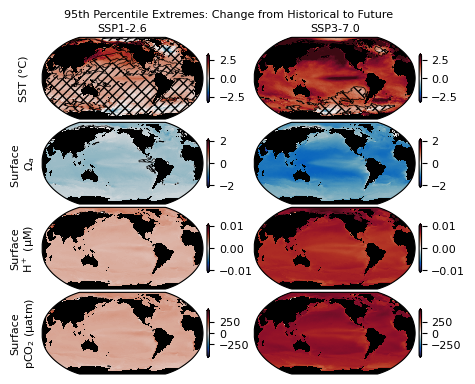

In [9]:
scenList=['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']
fig,ax=plt.subplots(5,3,figsize=(5.5,4.5),
                    subplot_kw={'projection':proj,'facecolor':'black'},
                    gridspec_kw={'hspace':.05,'wspace':.1,'height_ratios':[.08,1,1,1,1],'width_ratios':[.01,1,1]})
ax[0,0].remove()
for fi in range(1,3):
    ax[0,fi]=_repl(fig,ax[0,fi])
    ax[0,fi].text(-.45,.08,scenLabels[scenList[fi]],ha='center',va='center')#
    ax[0,fi].set_xlim(-.1,.1)
    ax[0,fi].set_axis_off()
for fj in range(1,5):
    ax[fj,0]=_repl(fig,ax[fj,0])
    ax[fj,0].text(.5,.5,varLabels[varlist[fj-1]],ha='center',va='center',rotation='vertical')
    ax[fj,0].set_axis_off()
extremes={}
vm={1:3,2:2,3:.01,4:50*1e6/101325}
for fi in range(1,3):
    for fj in range(1,5):
        scen=scenList[fi]
        ivar=varlist[fj-1]
        A=1e6/101325 if ivar=='spco2' else 1
        qq=qqh if exdir[ivar]>0 else qql
        delta=(stats[scen][ivar]['qt_dt'].sel(quantile=qq)-\
                stats['ESM4_historical_D1'][ivar]['qt_dt'].sel(quantile=qq))*A
        m=ax[fj,fi].pcolormesh(lons,lats,delta,transform=ccrs.PlateCarree(),cmap=cmb,
                               norm=mcol.CenteredNorm(vcenter=0,
                                    halfrange=vm[fj]))#2.5*np.sqrt(np.nansum(delta*delta)/np.sum(~np.isnan(delta)))))
        cb=fig.colorbar(m,ax=ax[fj,fi],shrink=.6,extend='both',pad=.02)
        ratio1=delta/devs[('ESM4_historical_D1',ivar)]*exdir[ivar]
        ratio2=delta/np.average(np.ma.masked_where(np.isnan(delta),devs[('ESM4_historical_D1',ivar)]),weights=wgt.fillna(0))*exdir[ivar]
        ax[fj,fi].contour(lons,lats,ratio1,levels=[2,],
                         transform=ccrs.PlateCarree(),
                         linewidths=.5,colors='k')
        mh1=ax[fj,fi].contourf(lons,lats,ratio1,levels=[-100,2,3],
                         transform=ccrs.PlateCarree(),
                         extend='max',colors='none',
                   hatches=['\\\\',None, None,])#hatches=[None, '\\','\\\\',])
        mh2=ax[fj,fi].contourf(lons,lats,ratio2,levels=[-100,2,3],
                         transform=ccrs.PlateCarree(),
                         extend='max',colors='none',
                   hatches=['////',None,None,])
fig.suptitle('95th Percentile Extremes: Change from Historical to Future',y=.92);
fig.savefig(f'delta_p95.png', dpi=300,bbox_inches='tight')

## extinction versus extirpation: are similar waters available? base on 95th percentile 

contour=440966.0434039835; percent enclosed ~0.9004111390598575
contour=437872.9217722993; percent enclosed ~0.8984655215685833
contour=545746.3922501899; percent enclosed ~0.8988439529745884
contour=1034373.1511737829; percent enclosed ~0.8988411004203368
contour=1112593.9754329661; percent enclosed ~0.9010991944878364
contour=804319.3396441424; percent enclosed ~0.8944994000323372


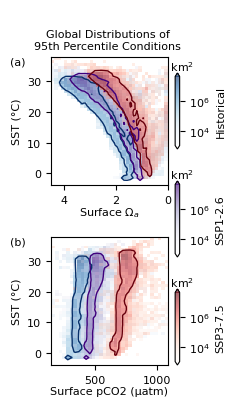

In [10]:
wgt=wgt*1e-6 # convert m2 to km2

colors1 = plt.get_cmap('Blues')(np.linspace(0,1,10))
colors1[:,-1]=np.linspace(.2,.6,10)
colors2 = plt.get_cmap('Purples')(np.linspace(0,1,10))
colors2[:,-1]=np.linspace(.2,.6,10)
colors3 = plt.get_cmap('Reds')(np.linspace(0,1,10))
colors3[:,-1]=np.linspace(.2,.6,10)

cm1=mcol.LinearSegmentedColormap.from_list('cm1', colors1)
cm2=mcol.LinearSegmentedColormap.from_list('cm2', colors2)
cm3=mcol.LinearSegmentedColormap.from_list('cm3', colors3)

cm1.set_under('w',alpha=0)
cm2.set_under('w',alpha=0)
cm3.set_under('w',alpha=0)

ix=viz.wet1x1>0
cmax=50000000 #2100*np.sum(wgt.fillna(0).data[ix])/np.sum(ix)
lnorm=mcol.LogNorm(vmin=1000,vmax=cmax)
def _pfun(c,h0):
    return (np.sum(np.where(h0>=c,h0,0))/np.sum(h0)-.9)**2

def _getc(h):
    oo=scopt.minimize_scalar(partial(_pfun,h0=h),bounds=[0,np.max(h)])
    print(f'contour={oo.x}; percent enclosed ~{np.sum(np.where(h>=oo.x,h,0))/np.sum(h)}')
    return oo.x

omedges=np.linspace(0,5,41)
tedges=np.linspace(-5,40,47)
cedges=np.linspace(0,120,41)

fig,ax=plt.subplots(2,1,figsize=(1.5,4),gridspec_kw={'hspace':.4,'wspace':.4})
row=0
iscen='ESM4_historical_D1'
xx=stats[iscen]['omega_arag_0']['qt_dt'].sel(quantile=qql).values
yy=stats[iscen]['tos']['qt_dt'].sel(quantile=qqh).values
h1,xe1,ye1=np.histogram2d(xx[ix],yy[ix],bins=[omedges,tedges],weights=wgt.fillna(0).data[ix])
#h1=h1*np.sum(ix)/np.sum(h1)
im1=ax[row].pcolormesh(xe1,ye1,h1.T,norm=lnorm,cmap=cm1,);
#ax[row].pcolormesh(xe1,ye1,h1.T,norm=lnorm,cmap=cm1,);
iscen='ESM4_ssp126_D1'
xx=stats[iscen]['omega_arag_0']['qt_dt'].sel(quantile=qql).values
yy=stats[iscen]['tos']['qt_dt'].sel(quantile=qqh).values
h2,xe2,ye2=np.histogram2d(xx[ix],yy[ix],bins=[omedges,tedges],weights=wgt.fillna(0).data[ix])
#h2=h2*np.sum(ix)/np.sum(h2)
im2=ax[row].pcolormesh(xe2,ye2,h2.T,norm=lnorm,cmap=cm2);
iscen='ESM4_ssp370_D1'
xx=stats[iscen]['omega_arag_0']['qt_dt'].sel(quantile=qql).values
yy=stats[iscen]['tos']['qt_dt'].sel(quantile=qqh).values
h3,xe3,ye3=np.histogram2d(xx[ix],yy[ix],bins=[omedges,tedges],weights=wgt.fillna(0).data[ix])
#h3=h3*np.sum(ix)/np.sum(h3)
im3=ax[row].pcolormesh(xe3,ye3,h3.T,norm=lnorm,cmap=cm3);

ax[row].contour(.5*(xe1[:-1]+xe1[1:]),.5*(ye1[:-1]+ye1[1:]),h1.T,np.array([_getc(h1),]),
                  colors=[colors1[-1,:],],alpha=1)
ax[row].contour(.5*(xe2[:-1]+xe2[1:]),.5*(ye2[:-1]+ye2[1:]),h2.T,np.array([_getc(h2),]),
                  colors=[colors2[-1,:],],alpha=1)
ax[row].contour(.5*(xe3[:-1]+xe3[1:]),.5*(ye3[:-1]+ye3[1:]),h3.T,np.array([_getc(h3),]),
                  colors=[colors3[-1,:],],alpha=1)

row=1
iscen='ESM4_historical_D1'
xx=stats[iscen]['spco2']['qt_dt'].sel(quantile=qqh).values
yy=stats[iscen]['tos']['qt_dt'].sel(quantile=qqh).values
h1,xe1,ye1=np.histogram2d(xx[ix],yy[ix],bins=[cedges,tedges],weights=wgt.fillna(0).data[ix])
#h1=h1*np.sum(ix)/np.sum(h1)
im1=ax[row].pcolormesh(xe1*1e6/101325,ye1,h1.T,norm=lnorm,cmap=cm1,);
iscen='ESM4_ssp126_D1'
xx=stats[iscen]['spco2']['qt_dt'].sel(quantile=qqh).values
yy=stats[iscen]['tos']['qt_dt'].sel(quantile=qqh).values
h2,xe2,ye2=np.histogram2d(xx[ix],yy[ix],bins=[cedges,tedges],weights=wgt.fillna(0).data[ix])
#h2=h2*np.sum(ix)/np.sum(h2)
im2=ax[row].pcolormesh(xe2*1e6/101325,ye2,h2.T,norm=lnorm,cmap=cm2);
iscen='ESM4_ssp370_D1'
xx=stats[iscen]['spco2']['qt_dt'].sel(quantile=qqh).values
yy=stats[iscen]['tos']['qt_dt'].sel(quantile=qqh).values
h3,xe3,ye3=np.histogram2d(xx[ix],yy[ix],bins=[cedges,tedges],weights=wgt.fillna(0).data[ix])
#h3=h3*np.sum(ix)/np.sum(h3)
im3=ax[row].pcolormesh(xe3*1e6/101325,ye3,h3.T,norm=lnorm,cmap=cm3);

ax[row].contour(.5*1e6/101325*(xe1[:-1]+xe1[1:]),.5*(ye1[:-1]+ye1[1:]),h1.T,np.array([_getc(h1),]),
                  colors=[colors1[-1,:],],alpha=1)
ax[row].contour(.5*1e6/101325*(xe2[:-1]+xe2[1:]),.5*(ye2[:-1]+ye2[1:]),h2.T,np.array([_getc(h2),]),
                  colors=[colors2[-1,:],],alpha=1)
ax[row].contour(.5*1e6/101325*(xe3[:-1]+xe3[1:]),.5*(ye3[:-1]+ye3[1:]),h3.T,np.array([_getc(h3),]),
                  colors=[colors3[-1,:],],alpha=1)

iax=ax[0]
iax.set_xlim(4.5,0)
iax.set_ylim(-4,38)
iax.set_xlabel('Surface $\Omega_a$',labelpad=0)
iax.set_ylabel('SST (°C)')
iax=ax[1]
iax.set_xlim(15*1e6/101325,110*1e6/101325)
iax.set_ylim(-4,38)
iax.set_xlabel('Surface pCO2 (μatm)',labelpad=1)
iax.set_ylabel('SST (°C)')
fig.suptitle('Global Distributions of\n95th Percentile Conditions',y=.95)
acb1=fig.add_axes([.951,.65,.03,.19])
acb2=fig.add_axes([.951,.38,.03,.19])
acb3=fig.add_axes([.951,.11,.03,.19])
fig.colorbar(im1,cax=acb1,label='Historical',extend='both')
fig.colorbar(im2,cax=acb2,label='SSP1-2.6',extend='both')
fig.colorbar(im3,cax=acb3,label='SSP3-7.5',extend='both')
acb1.set_title('   km$^2$',pad=-1)
acb2.set_title('   km$^2$',pad=-1)
acb3.set_title('   km$^2$',pad=-1)

axa=fig.add_axes(rect=[0,0,1,1])
axa.set_axis_off()
axa.annotate('(a)',xy=(-.15, 0.86),annotation_clip=False)
axa.annotate('(b)',xy=(-.15, 0.41),annotation_clip=False)
fig.savefig(f'distrib_p95_ii.png',dpi=300,bbox_inches='tight')